In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from shap import TreeExplainer, decision_plot
import matplotlib.pyplot as plt
df = pd.read_stata('data/ml_data.dta')
# plt.style.use('fivethirtyeight')

In [2]:
# Preprocessing

# No. of women in the household
df['a_women'] = (df['Gender'] == 'Female').astype(int)
women_by_hh = df.groupby('Common_ID')['a_women'].sum()
women_by_hh.name = 't_a_women'
df = df.merge(women_by_hh, left_on='Common_ID', right_index=True)
df['t_add_women'] = df['t_a_women'] - 1
df.rename({
    't_child': 'total_children',
    't_a_women': 'total_women',
    't_add_women': 'total_additional_women'
}, axis=1, inplace=True)

# Encode employment status
def enc_usual_principal_activity(val):
    # 1 "Self-Employed" 2 "Salaried Employee" 3 "Casual Labour" 0 "Not Employed"
    if val < 31:
        return "Self-Employed"
    if val == 31:
        return "Salaried Employee"
    if val in [41, 51]:
        return "Casual Labour"
    if val >= 81:
        return "Not Employed"
    return "EMP NA"
    
df['employment'] = df['usual_principal_activity__status'].map(enc_usual_principal_activity)



X = df[df['Age'] >= 15]
X[['paid_activity_time', 'unpaid_activity_time']] /= 60

# one-hot encode education as int
education_ohe = pd.get_dummies(X.pop('education'), dtype=int)
X = pd.concat((X, education_ohe), axis=1)

# OHE marital status
# 1 "Never Married" 2 "Currently Married" 3 "Widowed" 4 "Divorced"
marital_status = {1: 'Never Married', 2: 'Currently Married', 3: 'Widowed', 4: 'Divorced'}
X['marital_status'] = X['marital_status'].replace(marital_status)
marital_status_ohe = pd.get_dummies(X.pop('marital_status'), dtype=int)
X = pd.concat((X, marital_status_ohe), axis=1)

# OHE employment
emp_ohe = pd.get_dummies(X.pop('employment'), dtype=int)
X = pd.concat((X, emp_ohe), axis=1)

# OHE states
state_ohe = pd.get_dummies(X.pop('state_codes'), dtype=int)
X = pd.concat((X, state_ohe), axis=1)


# (X, y)s of the four regressions

catCols = education_ohe.columns.tolist() + marital_status_ohe.columns.tolist() + emp_ohe.columns.tolist() # + state_ohe.columns.tolist()
male_feats = ['age', 'total_children', 'total_women'] + catCols
female_feats = ['age', 'total_children', 'total_additional_women'] + catCols

male_X = X[X['Gender'] == 'Male']
female_X = X[X['Gender'] == 'Female']

male_X_paid, male_y_paid = male_X[male_feats], male_X['paid_activity_time']
female_X_paid, female_y_paid = female_X[female_feats], female_X['paid_activity_time']

male_X_unpaid, male_y_unpaid = male_X[male_feats], male_X['unpaid_activity_time']
female_X_unpaid, female_y_unpaid = female_X[female_feats], female_X['unpaid_activity_time']

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

In [3]:
# Regressions
# 1. Male, paid

male_paid_tree = DecisionTreeRegressor()
print(male_paid_tree.fit(male_X_paid, male_y_paid).score(male_X_paid, male_y_paid))

highestX = male_X_paid[male_y_paid > 15].sample(10)
lowestX = male_X_paid[male_y_paid == 0].sample(10)
samples = pd.concat((highestX, lowestX),  axis=0, ignore_index=True)
# exp = TreeExplainer(male_paid_tree)
# decision_plot(exp.expected_value, exp.shap_values(samples), feature_names=male_paid_tree.feature_names_in_)

0.5050621730373188


Text(0.5, 1.0, 'Hello')

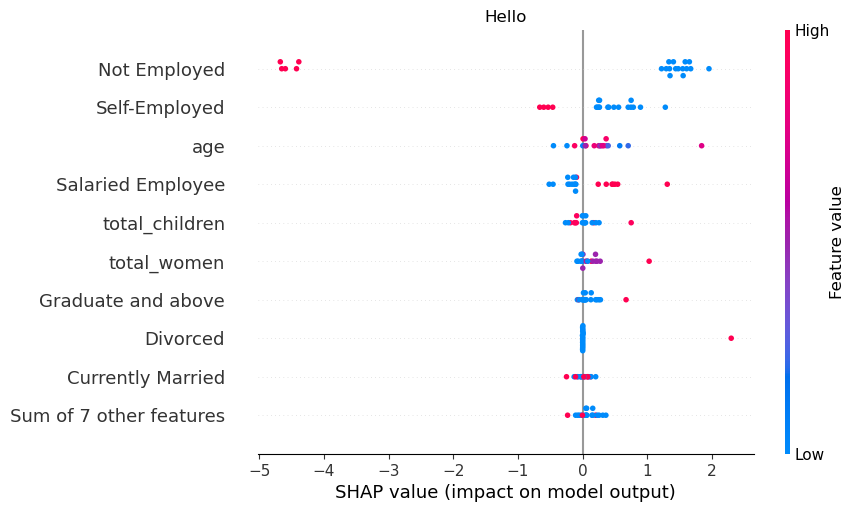

In [4]:
explainer = TreeExplainer(male_paid_tree)
explanation = explainer(samples)
from shap.plots import beeswarm

beeswarm(explanation, show=False)
plt.gca().set_title("Hello")

In [7]:
from shap import initjs
initjs()

In [13]:
from shap.plots import force
force(explanation[:2, ...])

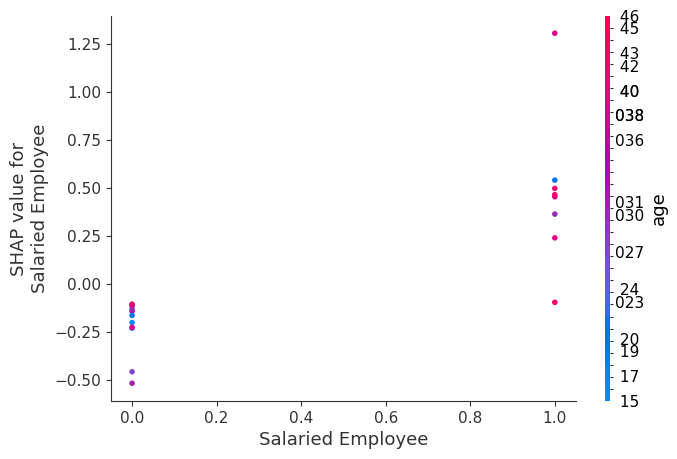

In [20]:
dependence_plot("Salaried Employee", explanation.values, samples, display_features=samples)

In [22]:
from shap.plots import waterfall

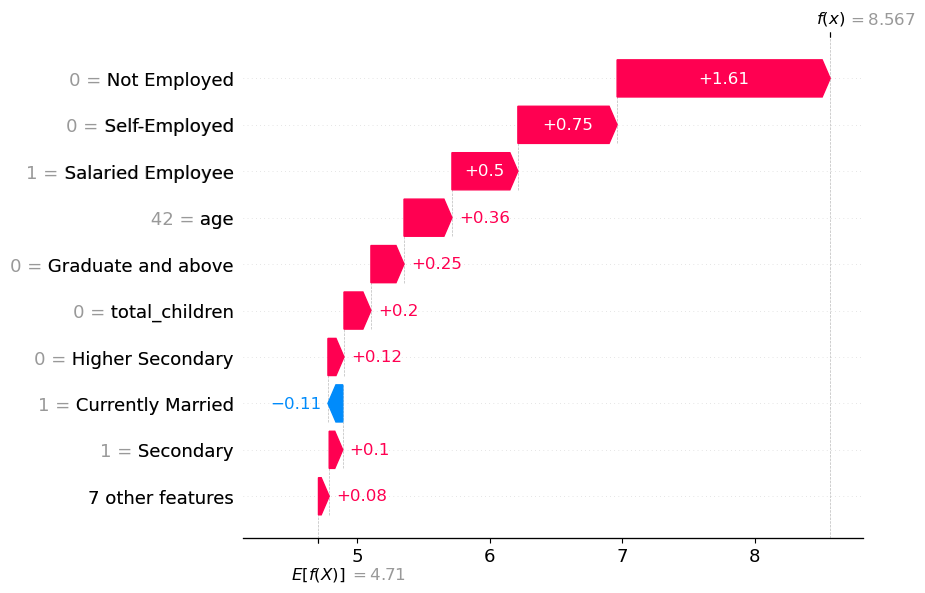

In [31]:
waterfall(explanation[2])

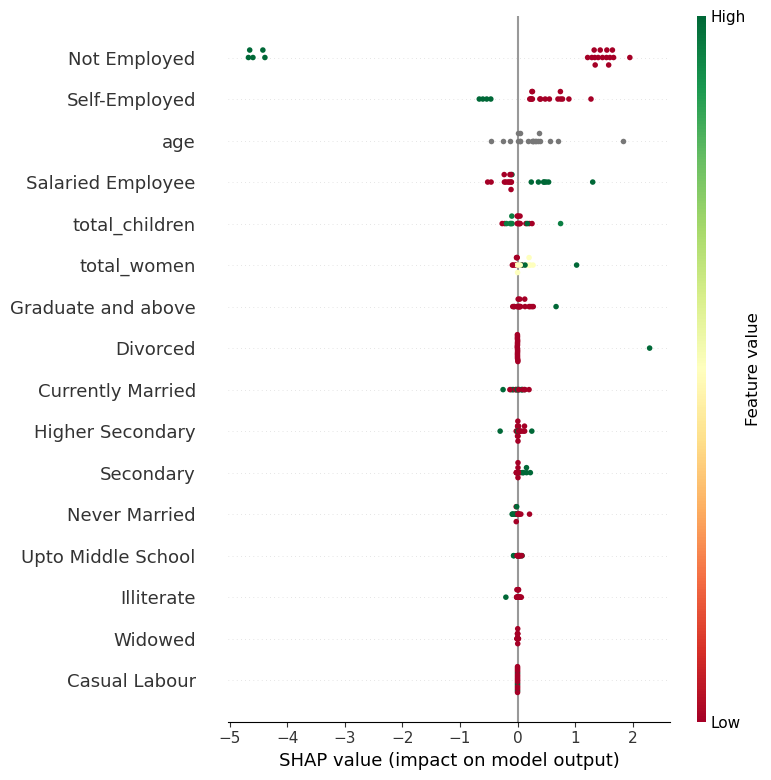

In [42]:
summary_plot(explanation.values, samples, cmap='RdYlGn')

In [33]:
summary_plot?

Signature:
summary_plot(
    shap_values,
    features=None,
    feature_names=None,
    max_display=None,
    plot_type=None,
    color=None,
    axis_color='#333333',
    title=None,
    alpha=1,
    show=True,
    sort=True,
    color_bar=True,
    plot_size='auto',
    layered_violin_max_num_bins=20,
    class_names=None,
    class_inds=None,
    color_bar_label='Feature value',
    cmap=<matplotlib.colors.LinearSegmentedColormap object at 0x7f5559847670>,
    show_values_in_legend=False,
    auto_size_plot=None,
    use_log_scale=False,
)
Docstring:
Create a SHAP beeswarm plot, colored by feature values when they are provided.

Parameters
----------
shap_values : numpy.array
    For single output explanations this is a matrix of SHAP values (# samples x # features).
    For multi-output explanations this is a list of such matrices of SHAP values.

features : numpy.array or pandas.DataFrame or list
    Matrix of feature values (# samples x # features) or a feature_names list as sho

<Axes: >

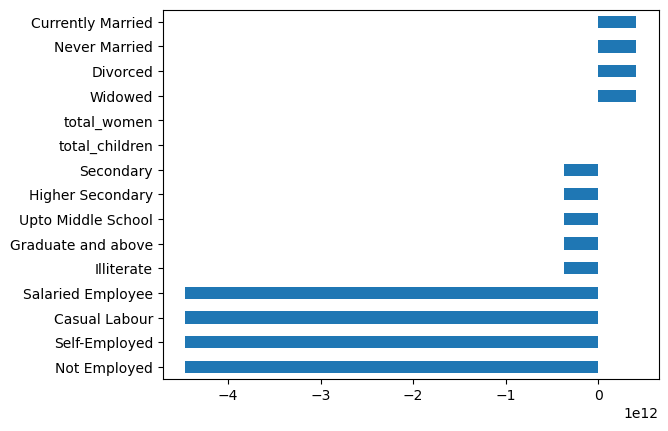

In [26]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(male_X_paid, male_y_paid)
pd.Series(lr.coef_, index=lr.feature_names_in_).sort_values().plot(kind='barh')

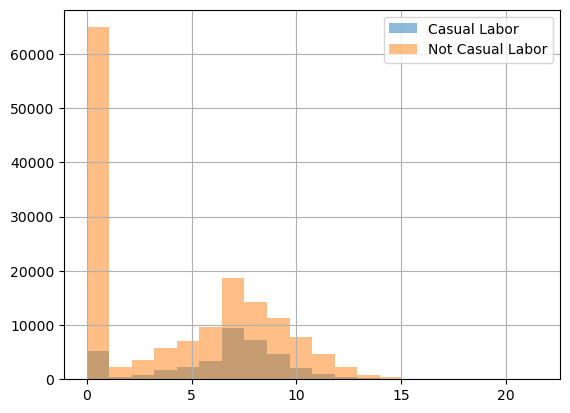

In [31]:
ax = male_y_paid[male_X_paid['Casual Labour'].astype(bool)].hist(bins=20, alpha=0.5, label="Casual Labor")
male_y_paid[~male_X_paid['Casual Labour'].astype(bool)].hist(bins=20, alpha=0.5, label="Not Casual Labor",  ax=ax)
plt.legend()

In [12]:
(male_y_paid == 0).sum()

68552

In [17]:
(male_y_paid > 15).sum()

165

0.11396688893730067


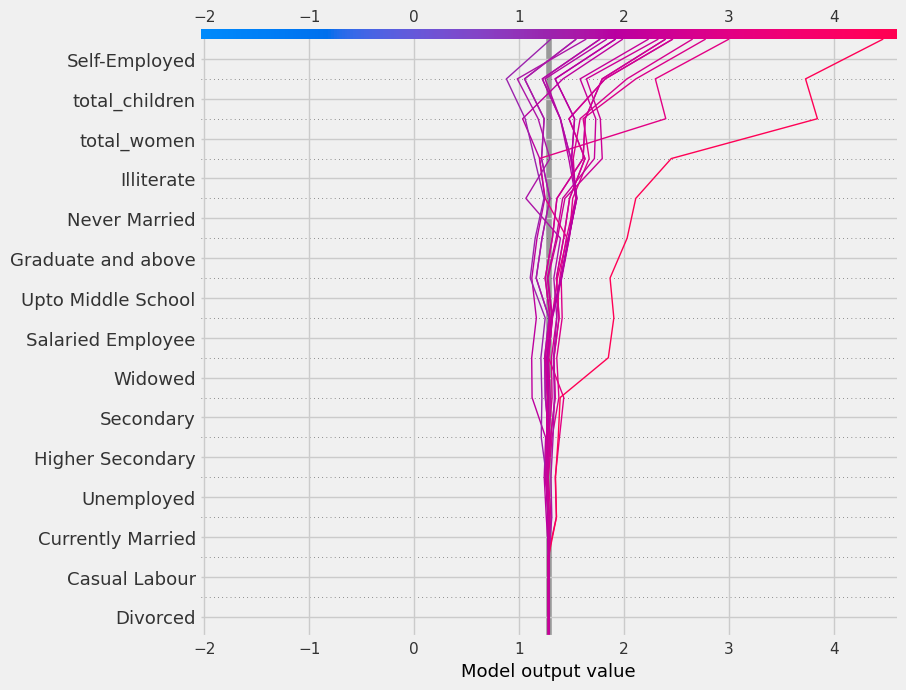

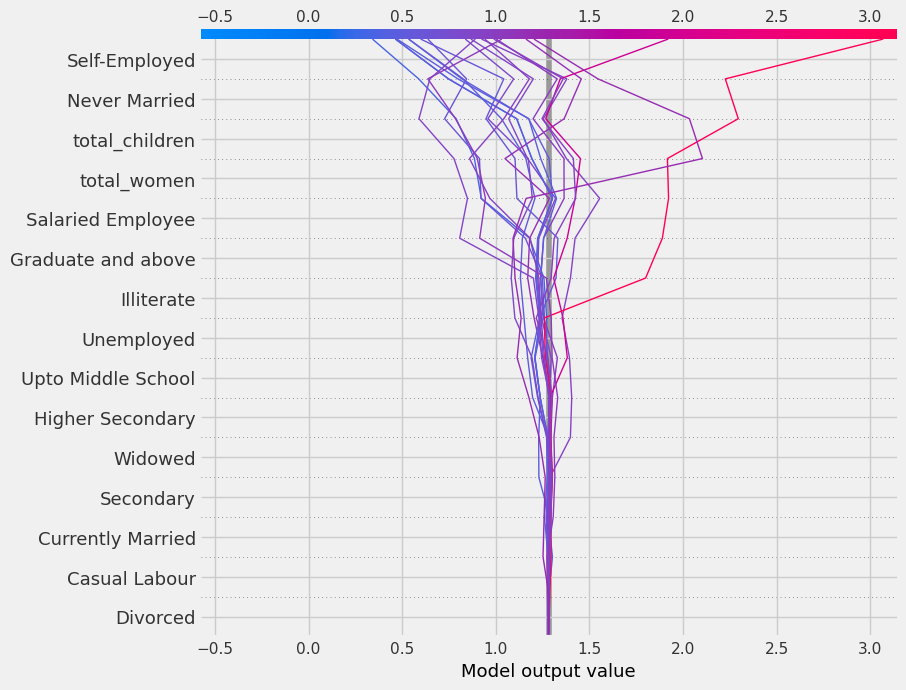

In [31]:
# Regressions
# 1. Male, unpaid

male_unpaid_tree = DecisionTreeRegressor()
print(male_unpaid_tree.fit(male_X_unpaid, male_y_unpaid).score(male_X_unpaid, male_y_unpaid))

highestX = male_X_unpaid[male_y_unpaid > 10].sample(20)
lowestX = male_X_unpaid[male_y_unpaid == 0].sample(20)
exp = TreeExplainer(male_unpaid_tree)
decision_plot(exp.expected_value, exp.shap_values(highestX), feature_names=male_unpaid_tree.feature_names_in_)
decision_plot(exp.expected_value, exp.shap_values(lowestX), feature_names=male_unpaid_tree.feature_names_in_)

In [ ]:
male_

0.5376714371207996


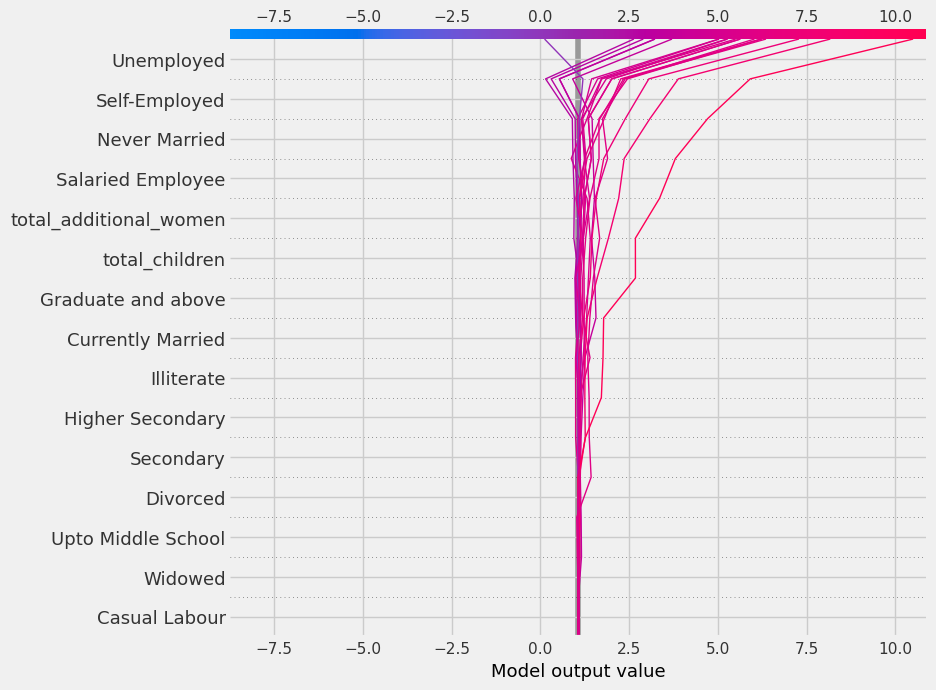

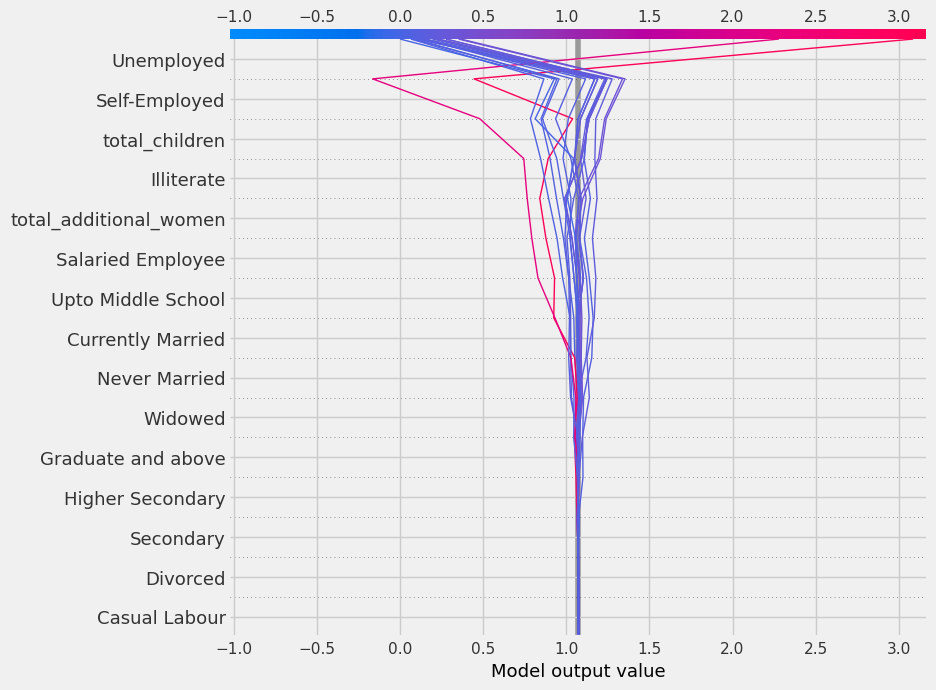

In [32]:
# Regressions
# 1. Female, paid

female_paid_tree = DecisionTreeRegressor()
print(female_paid_tree.fit(female_X_paid, female_y_paid).score(female_X_paid, female_y_paid))
highestX = female_X_paid[female_y_paid > 10].sample(20)
lowestX = female_X_paid[female_y_paid == 0].sample(20)
exp = TreeExplainer(female_paid_tree)
decision_plot(exp.expected_value, exp.shap_values(highestX), feature_names=female_paid_tree.feature_names_in_)
decision_plot(exp.expected_value, exp.shap_values(lowestX), feature_names=female_paid_tree.feature_names_in_)

0.41048968002608777


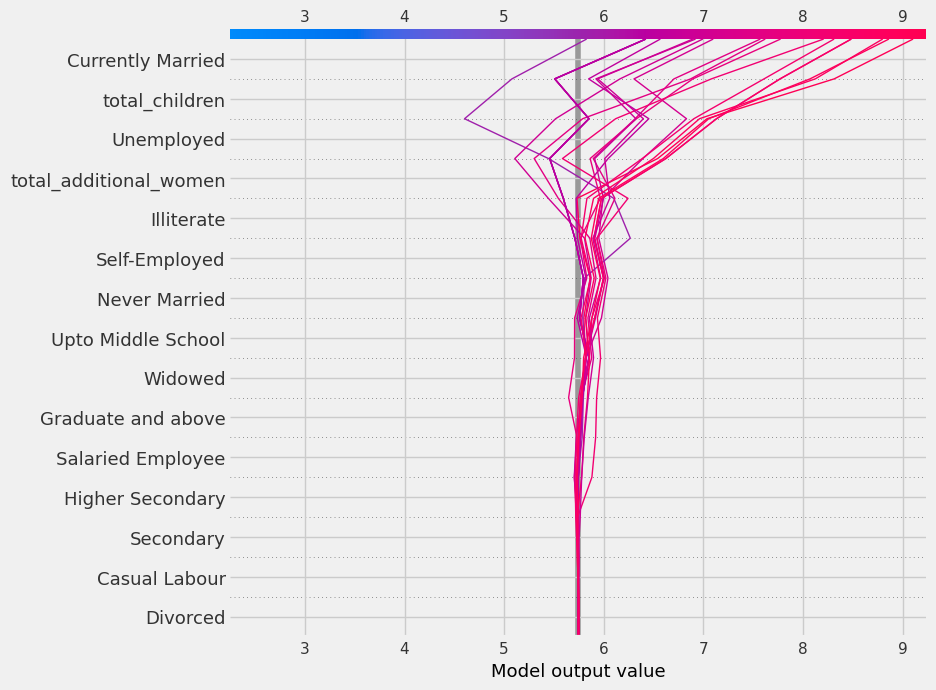

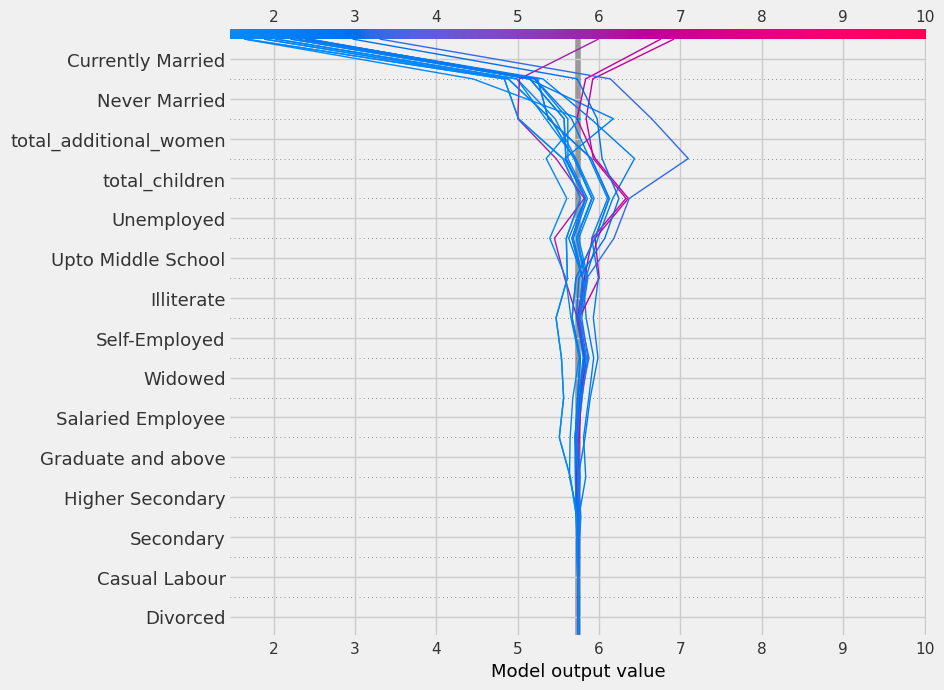

In [33]:
# Regressions
# 1. Female, unpaid

female_unpaid_tree = DecisionTreeRegressor()
print(female_unpaid_tree.fit(female_X_unpaid, female_y_unpaid).score(female_X_unpaid, female_y_unpaid))
highestX = female_X_unpaid[female_y_unpaid > 10].sample(20)
lowestX = female_X_unpaid[female_y_unpaid == 0].sample(20)
exp = TreeExplainer(female_unpaid_tree)
decision_plot(exp.expected_value, exp.shap_values(highestX), feature_names=female_unpaid_tree.feature_names_in_)
decision_plot(exp.expected_value, exp.shap_values(lowestX), feature_names=female_unpaid_tree.feature_names_in_)